In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import builtins
import keras
import tensorflow as tf
import math
from extra_keras_metrics import average_precision_at_k

Using TensorFlow backend.


In [3]:
import random
import keras_metrics as km

In [4]:
import sys
sys.path.append('..')

In [5]:
from data_loader import data_generator

In [6]:
tf.__version__

'1.14.0'

In [636]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)


In [614]:
class RecoDNN():
    
    def __init__(self, max_transaction_history = 50, max_product_click_history = 50, max_promotion_click_history = 50,
                 category_size = 100, single_categorical_features = None, numeric_features_size = 10,
                 hidden_layer1_size = 256, hidden_layer2_size = 128, hidden_layer3_size = 64, activation='relu',
                input_embedding_size = 128):
        
        self.max_transaction_history = max_transaction_history
        self.max_product_click_history = max_product_click_history
        self.max_promotion_click_history = max_promotion_click_history
        self.category_size = category_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.hidden_layer3_size = hidden_layer3_size
        self.single_categorical_features = single_categorical_features
        self.numeric_features_size = numeric_features_size
        self.activation = activation
        self.input_embedding_size = input_embedding_size
        
        self.category_embeddings = tf.keras.layers.Embedding(output_dim=self.input_embedding_size, 
                                                             input_dim = self.category_size, mask_zero=True, name='category_embeddings')
        
        self.build()
        
    
    def build(self):
        
        inp_layer, inp_embed = self.create_input()
        v = tf.keras.layers.Dense(512, activation = self.activation, kernel_initializer='he_normal')(tf.keras.layers.concatenate(inp_embed)) 
        v = tf.keras.layers.Dense(self.hidden_layer1_size, activation = self.activation, kernel_initializer='he_normal')(v) 
        v = tf.keras.layers.Dense(self.hidden_layer2_size, activation = self.activation, kernel_initializer='he_normal')(v)
        v = tf.keras.layers.Dense(self.hidden_layer3_size, activation = self.activation, kernel_initializer='he_normal',name='user_embedding')(v)
        output = tf.keras.layers.Dense(self.category_size, activation ='sigmoid', name='sigmoid')(v)
        self.model = tf.keras.models.Model(inputs = inp_layer, outputs = [output])    
        
    
    def create_input(self):
        
        transaction_cols = [x for x in range(self.max_transaction_history)]
        product_click_cols = [x for x in range(self.max_product_click_history)]
        promotion_click_cols = [x for x in range(self.max_promotion_click_history)]
        seq_category_cols = [transaction_cols, product_click_cols, promotion_click_cols]
        
        seqs = []
        for i, grp in enumerate(seq_category_cols):
            seqs.append(self.seq_categorical_input('seq_categorical_' + str(i), len(grp)))

        singles = []
        if self.single_categorical_features:
            for col in self.single_categorical_features:
                singles.append(self.singe_categorical_input(str(col), self.single_categorical_features[col][0],
                                                           self.single_categorical_features[col][1]))

        nums = self.continous_inputs(self.numeric_features_size)

        inp_layer =  [s[0] for s in seqs]
        inp_layer += [s[0] for s in singles]
        inp_layer.append(nums[0])
        inp_embed = [s[1] for s in seqs]
        inp_embed += [s[1] for s in singles]
        inp_embed.append(nums[1])
               
        return inp_layer, inp_embed
    
    
    def seq_categorical_input(self, name, max_history):
    
        seq = tf.keras.layers.Input(shape=(max_history,), dtype='int32', name=name)
        category_embeddings = tf.keras.layers.Embedding(output_dim=self.input_embedding_size,input_dim = self.category_size, name=name+'category_embeddings')
        input_embeddings = category_embeddings(seq)
        
        #avg_embedding = tf.keras.layers.GlobalAveragePooling1D(name=name + '_avg_embedding')(input_embeddings, mask=self.category_embeddings.compute_mask(seq))
        #cat_embeddings = tf.reshape(input_embeddings, [, -1])

        #maxf = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=1), name = name + '_max_embedding')
        #max_embedding = maxf(input_embeddings)

        #return seq, avg_embedding
        return seq, tf.keras.layers.Flatten(name = 'flatten_' + name)(input_embeddings)   #keras.layers.add([avg_embedding, max_embedding])
        #return seq, tf.keras.layers.concatenate([avg_embedding, max_embedding])

    
    def singe_categorical_input(self, name, unique_size, embedding_size):
        single = tf.keras.layers.Input(shape=(1,), dtype='int32', name=name)
        embeddings = tf.keras.layers.Embedding(output_dim = embedding_size, input_dim = unique_size, 
                           input_length=1, name=name + '_embedding')(single)
        embeddings = tf.keras.layers.Flatten(name = 'flatten_' + name)(embeddings)
        return single, embeddings
    
    def continous_inputs(self, size=None, name='numeric'):
        inp = tf.keras.layers.Input(shape=(size,), dtype='float32', name=name)
        return inp, inp


# fake dataset

In [450]:
data_size = 500
max_transaction_history = 20
max_product_click_history = 20
max_promotion_click_history = 20
input_embedding_size = 8
category_size = 5
numeric_size = 1
k=2

data1 = np.random.randint(category_size, size=(data_size, random.randint(1,max_transaction_history)))
data1 = tf.keras.preprocessing.sequence.pad_sequences(data1, max_transaction_history, padding='post')
#data1 = np.array([[1,2], [1,2,4]])

data2 = np.random.randint(category_size, size=(data_size, max_product_click_history-3))
data2 = tf.keras.preprocessing.sequence.pad_sequences(data2, max_product_click_history, padding='post')

data3 = np.random.randint(category_size, size=(data_size, max_promotion_click_history-4))
data3 = tf.keras.preprocessing.sequence.pad_sequences(data3, max_promotion_click_history, padding='post')

inputs = [data1, data2, data3]

single_category_cols = {105:(3,8),106:(5,8),107:(10,8)}   ## such as location : unique_value_size
for key in single_category_cols:
    inputs.append(np.random.randint(single_category_cols[key][0], size=(data_size, 1)))

num1 = np.random.random(size=(data_size, numeric_size))
inputs.append(num1)

ninputs = np.hstack(inputs)

labels = np.random.randint(0, category_size-1, size=(data_size, k))
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=category_size)

In [452]:
ninputs.shape

(500, 64)

In [326]:
multi_hot_labels=[]
for label in labels:
    mh_encode = np.zeros(category_size)
    mh_encode[label] = 1
    multi_hot_labels.append(mh_encode)
    #break
#print(multi_hot_labels)
#multi_hot_labels = tf.convert_to_tensor_or_sparse_tensor(np.array(multi_hot_labels))
multi_hot_labels = np.array(multi_hot_labels, dtype=np.int8)

In [414]:
multi_hot_labels.shape

(500, 5)

In [551]:
multi_hot_labels[0]

array([0, 0, 1, 1, 0], dtype=int8)

In [550]:
np.nonzero(multi_hot_labels[0])

(array([2, 3]),)

# Training

In [531]:
from itertools import tee  # finally! I found something useful for it
from sklearn import metrics

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, features, labels, validation_steps=None, threshold=0.5):
        self.features = features
        self.labels = labels
        self.validation_steps = validation_steps if validation_steps else len(self.labels)
        print('validation_steps', self.validation_steps)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        print('\n\nepoch', epoch)
        # duplicate generator to make sure y_true and y_pred are calculated from the same observations
        #gen_1, gen_2 = tee(self.validation_set)
        #y_true = np.vstack(labels for _ in range(self.validation_steps)).astype('int')
        y_true = self.labels
        y_pred = (self.model.predict(self.features, batch_size=20) > self.threshold).astype('int')
        #print(y_true.shape)
        #print(y_pred.shape)
        f1 = metrics.f1_score(y_true, y_pred, average='weighted')
        precision = metrics.precision_score(y_true, y_pred, average='weighted')
        recall = metrics.recall_score(y_true, y_pred, average='weighted')
        self.val_f1_scores.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)
        print(f" - val_f1_score: {f1:.5f} - val_precision: {precision:.5f} - val_recall: {recall:.5f}")

In [532]:
def top_2(y_true, y_pred):
    return tf.keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=2) 

In [533]:
def tf_loss_wrapper(y_true, y_pred, loss):
    score, up_opt = loss(tf.cast(y_true,tf.int64), tf.cast(y_pred,tf.float32), k=2) 
    tf.keras.backend.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [534]:
def average_precision_at_k(y_true, y_pred):
    score, up_opt = tf.metrics.average_precision_at_k(tf.cast(y_true,tf.int64), tf.cast(y_pred,tf.float32), k=2) 
    tf.keras.backend.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [535]:
def precision_at_2(y_true, y_pred):
    return tf.metrics.precision_at_k(tf.cast(y_true,tf.int64), y_pred, k=2) 

In [536]:
def precision_at_1(y_true, y_pred):
    zero = tf.constant(0, dtype=tf.float32)
    where = tf.not_equal(y_true, zero)
    idx = tf.where(where)
    print(idx)
    return tf.metrics.precision_at_k(idx, y_pred, k=1) 

In [537]:
def overlapping_at_2(y_true, y_pred):
    sidx = np.argsort(y_pred)
    idx = sidx[:2]
    
    return 0

In [538]:
def tf_accuracy(y_true, y_pred):
    score, up_opt = tf.metrics.accuracy(y_true, tf.round(y_pred))
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [632]:
def train_input():    
    '''
    for i in range(500):
        yield [inputs[j] for j in range(len(inputs))], multi_hot_labels[i]
    '''
    return inputs, multi_hot_labels

In [576]:
def sigmoid_cross_entropy_with_logits(y_true, y_pred):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true)
    loss = tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss

In [639]:
model = RecoDNN(max_transaction_history, max_product_click_history, max_promotion_click_history, category_size,
                numeric_features_size = numeric_size, input_embedding_size = input_embedding_size,
                single_categorical_features = single_category_cols).model

In [640]:
model.compile(loss='binary_crossentropy',
    #loss = sigmoid_cross_entropy_with_logits,
                       optimizer=tf.keras.optimizers.Adam(0.001),
                       metrics=['accuracy'])

In [634]:
model_est=tf.keras.estimator.model_to_estimator(keras_model=model, model_dir="kkt")

In [641]:
model_est.train(input_fn=train_input, steps=1000)

I0815 09:49:09.640091 4572042688 estimator.py:1145] Calling model_fn.
I0815 09:49:13.770554 4572042688 estimator.py:1147] Done calling model_fn.
I0815 09:49:13.771621 4572042688 estimator.py:1364] Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='kkt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
I0815 09:49:13.772028 4572042688 warm_starting_util.py:419] Warm-starting from: ('kkt/keras/keras_model.ckpt',)
I0815 09:49:13.772552 4572042688 warm_starting_util.py:333] Warm-starting variables only in TRAINABLE_VARIABLES.
I0815 09:49:13.815333 4572042688 warm_starting_util.py:481] Warm-started 16 variables.
I0815 09:49:13.816998 4572042688 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
I0815 09:49:13.941338 4572042688 monitored_session.py:240] Graph was finalized.
I0815 09:49:13.943490 4572042688 saver.py:1280] Restoring parameters from kkt/model.ckpt-200
I0815 09:49:14.028549 4572042688 

In [642]:
model_est.evaluate(input_fn=train_input, steps=100)

I0815 09:49:21.682789 4572042688 estimator.py:1145] Calling model_fn.
I0815 09:49:21.904263 4572042688 estimator.py:1147] Done calling model_fn.
I0815 09:49:21.923299 4572042688 evaluation.py:255] Starting evaluation at 2019-08-15T09:49:21Z
I0815 09:49:22.012088 4572042688 monitored_session.py:240] Graph was finalized.
I0815 09:49:22.013727 4572042688 saver.py:1280] Restoring parameters from kkt/model.ckpt-1200
I0815 09:49:22.051066 4572042688 session_manager.py:500] Running local_init_op.
I0815 09:49:22.061838 4572042688 session_manager.py:502] Done running local_init_op.
I0815 09:49:22.135637 4572042688 evaluation.py:167] Evaluation [10/100]
I0815 09:49:22.158746 4572042688 evaluation.py:167] Evaluation [20/100]
I0815 09:49:22.182600 4572042688 evaluation.py:167] Evaluation [30/100]
I0815 09:49:22.205085 4572042688 evaluation.py:167] Evaluation [40/100]
I0815 09:49:22.229595 4572042688 evaluation.py:167] Evaluation [50/100]
I0815 09:49:22.253997 4572042688 evaluation.py:167] Evaluati

{'acc': 1.0, 'loss': 1.62937e-07, 'global_step': 1200}

In [617]:
tf.keras.backend.get_session().run(tf.local_variables_initializer())

In [618]:
#model.summary()

In [619]:
#tf.keras.utils.plot_model(model, to_file='../figures/model.png', show_shapes=True, show_layer_names=True)

In [620]:
sm=Metrics([inputs[i][20:100] for i in range(len(inputs))], multi_hot_labels[20:100])

validation_steps 80


In [621]:
history = model.fit(x=inputs, y=multi_hot_labels, validation_split=0.1, epochs=20, batch_size=20, callbacks=[sm])

Train on 450 samples, validate on 50 samples
Epoch 1/20
240/450 [===============>..............] - ETA: 0s - loss: 0.6149 - acc: 0.6050 

epoch 0
 - val_f1_score: 0.14182 - val_precision: 0.10105 - val_recall: 0.23776
450/450 [==============================] - 4s 10ms/sample - loss: 0.5917 - acc: 0.6169 - val_loss: 0.5475 - val_acc: 0.6560
Epoch 2/20
240/450 [===============>..............] - ETA: 0s - loss: 0.5534 - acc: 0.6242

epoch 1
 - val_f1_score: 0.20158 - val_precision: 0.17496 - val_recall: 0.23776
450/450 [==============================] - 0s 314us/sample - loss: 0.5507 - acc: 0.6364 - val_loss: 0.5537 - val_acc: 0.6400
Epoch 3/20
 20/450 [>.............................] - ETA: 0s - loss: 0.5512 - acc: 0.6700

/Users/pengcheng.jia/anaconda3/envs/reco/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pengcheng.jia/anaconda3/envs/reco/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/pengcheng.jia/anaconda3/envs/reco/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pengcheng.jia/anaconda3/envs/reco/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', 

420/450 [===========================>..] - ETA: 0s - loss: 0.5393 - acc: 0.6671

epoch 2
 - val_f1_score: 0.27606 - val_precision: 0.29279 - val_recall: 0.34266
450/450 [==============================] - 0s 347us/sample - loss: 0.5384 - acc: 0.6689 - val_loss: 0.5637 - val_acc: 0.6200
Epoch 4/20
240/450 [===============>..............] - ETA: 0s - loss: 0.5178 - acc: 0.6900

epoch 3
 - val_f1_score: 0.54013 - val_precision: 0.78874 - val_recall: 0.48252
450/450 [==============================] - 0s 294us/sample - loss: 0.5134 - acc: 0.6996 - val_loss: 0.5745 - val_acc: 0.6360
Epoch 5/20
260/450 [================>.............] - ETA: 0s - loss: 0.4704 - acc: 0.7431

epoch 4
 - val_f1_score: 0.67908 - val_precision: 0.79436 - val_recall: 0.71329
450/450 [==============================] - 0s 294us/sample - loss: 0.4678 - acc: 0.7493 - val_loss: 0.6757 - val_acc: 0.5560
Epoch 6/20
260/450 [================>.............] - ETA: 0s - loss: 0.4119 - acc: 0.7900

epoch 5
 - val_f1_score: 0.8

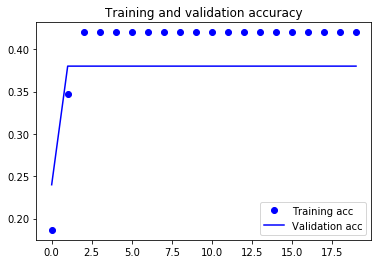

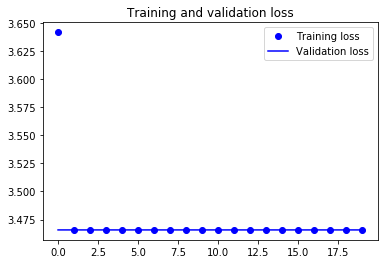

In [611]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [315]:
model.save('../outputs/reco_dnn.h5')  # save model 

In [280]:
model.evaluate(inputs, multi_hot_labels)

500/500 [==============================] - 0s 718us/sample - loss: 4.5309e-04 - acc: 1.0000 - tf_accuracy: 0.0804


[0.00045308884559199213, 1.0, 0.08043264]

# infere user embedding

In [262]:
lmodel = tf.keras.models.load_model('../outputs/reco_dnn.h5', compile=False)

In [263]:
layer_name = 'user_embedding'
intermediate_layer_model = tf.keras.Model(inputs=lmodel.input,
                                 outputs=lmodel.get_layer(layer_name).output)


In [264]:
sz=3  # use first three rows as inputs
dat = inputs[0][0:sz], inputs[1][0:sz],inputs[2][0:sz],inputs[3][0:sz],inputs[4][0:sz],inputs[5][0:sz],inputs[6][0:sz]

In [265]:
intermediate_output = intermediate_layer_model.predict(dat)

In [266]:
intermediate_output   # these are embeddings for users

array([[ 0.        ,  0.        , 11.98904   ,  9.113922  ,  0.        ,
         0.        , 21.0179    ,  0.        , 17.729858  ,  0.        ,
         6.1496673 , 10.724029  ,  6.9300375 ,  0.        ,  7.4779935 ,
         7.5301666 ,  7.3297377 ,  6.8732986 ,  0.        ,  0.        ,
         0.        ,  0.        ,  2.1289222 ,  0.        , 10.810701  ,
         7.4345446 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.3126397 ,  0.        ,  0.        ,  0.        ,
         0.        ,  2.4478593 ,  6.635885  ,  0.        ,  0.        ,
         6.822124  ,  0.        ,  0.        , 13.865654  ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  8.586072  ,
         0.        ,  4.683244  ,  0.3855984 ,  0.        ,  0.        ,
         0.        ,  1.6309222 ,  0.        ,  0.        ,  0.        ,
         3.7835302 ,  0.9176029 ,  0.8315637 ,  0.        ],
       [ 0.        ,  0.        ,  3.8426456 ,  2.8792574 ,  0.

In [267]:
p=lmodel.predict(dat)
p

array([[2.0861626e-07, 1.2609363e-04, 9.9842501e-01, 9.9996066e-01,
        0.0000000e+00],
       [9.9958515e-01, 7.2628260e-05, 9.9902403e-01, 3.4957218e-05,
        0.0000000e+00],
       [4.7533883e-04, 9.9914777e-01, 9.9993169e-01, 7.4460684e-07,
        0.0000000e+00]], dtype=float32)

In [278]:
np.argsort(p)[:, -2:]

array([[2, 3],
       [2, 0],
       [1, 2]])

In [364]:
multi_hot_labels[:3]

array([[0, 0, 1, 1, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0]], dtype=int8)

In [269]:
np.argmax([0,1,1,0])

1